# Convolutional Neural Networks

In this assignment, you'll be coding up a convolutional neural network from scratch to classify images using PyTorch.  

### Instructions
- The maximum number of parameters you are allowed to use for your network is **100,000**. 
- You are required to complete the functions defined in the code blocks following each question. Fill out sections of the code marked `"YOUR CODE HERE"`.
- You're free to add any number of methods within each class.
- You may also add any number of additional code blocks that you deem necessary. 
- Once you've filled out your solutions, submit the notebook on Canvas following the instructions [here](https://people.engr.tamu.edu/guni/csce421/assignments.html).
- Do **NOT** forget to type in your name and UIN at the beginning of the notebook.
- Make sure the notebook runs on google colab **WITHOUT** any issues when all cells are ran sequentially (includes installation of libraries). Points might be deducted if there are any bugs present.

## Install Dependencies

In [ ]:
!pip install torchinfo

In [ ]:
# Checking if hardware acceleration enabled
import os 
if int(os.environ['COLAB_GPU']) > 0:
  print ("*** GPU connected")
else:
  print ("*** No hardware acceleration: change to GPU under Runtime > Change runtime type > Hardware accelerator")

*** GPU connected


## Data Preparation

In [ ]:
# Importing the libraries
import os
import torch
import torchvision
from torchvision.utils import make_grid
from PIL import Image
import requests

import numpy as np

In this assignment, we will use the Fashion-MNIST dataset. Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  

### Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  

### Labels

Each training and test example is assigned to one of the following labels:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Fashion-MNIST is included in the `torchvision` library.

In [ ]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation

In [ ]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(),
    Normalize((0.5,), (0.5,)),
    RandomRotation(20)
    ])

# Download the data
dataset = FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



**NOTE:** You may add more operations to `Compose` if you're performing data augmentation.

## Data Exploration

Let's take a look at the classes in our dataset.

In [ ]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [ ]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: {} ({})'.format(dataset.classes[label], label))
    plt.imshow(img.squeeze(), cmap='Greys_r')
    plt.axis(False)

Label: Dress (3)


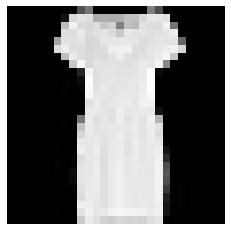

In [ ]:
show_example(*dataset[20])

Label: Sneaker (7)


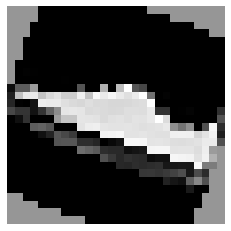

In [ ]:
show_example(*dataset[20000])

## Question 1

## Creating Training and Validation Datasets

The `split_indices` function takes in the size of the entire dataset, `n`, the fraction of data to be used as validation set, `val_frac`, and the random seed and returns the indices of the data points to be added to the validation dataset.  

**Choose a suitable fraction for your validation set and experiment with the seed. Remember that the better your validation set, the higher the chances that your model would do well on the test set.**

In [ ]:
def split_indices(n, val_frac, seed):
    # Determine the size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [ ]:
######################
#   YOUR CODE HERE   #
######################
val_frac =  0.08## Set the fraction for the validation set
rand_seed =  101 ## Set the random seed

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print("#samples in training set: {}".format(len(train_indices)))
print("#samples in validation set: {}".format(len(val_indices)))

#samples in training set: 55200
#samples in validation set: 4800


Next, we make use of the built-in dataloaders in PyTorch to create iterables of our our training and validation sets. This helps in avoiding fitting the whole dataset into memory and only loads a batch of the data that we can decide. 

**Set the `batch_size` depending on the hardware resource (GPU/CPU RAM) you are using for the assignment.**

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [ ]:
######################
#   YOUR CODE HERE   #
######################
batch_size = 64

In [ ]:
# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size,
                   sampler=val_sampler)

Plot images in a sample batch of data.

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, 8).permute(1, 2, 0), cmap='Greys_r')
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


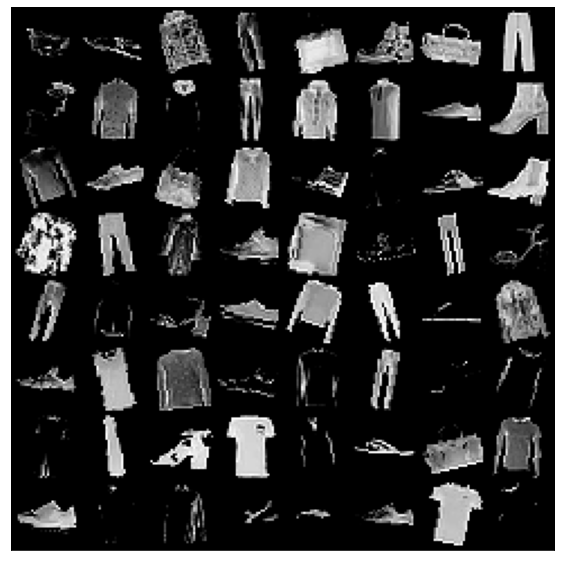

In [ ]:
show_batch(train_dl)

## Question 2

## Building the Model

**Create your model by defining the network architecture in the `ImageClassifierNet` class.**  
**NOTE:** The number of parameters in your network must be $\leq$ 100,000.

In [ ]:
# Import the libraries
import torch.nn as nn
import torch.nn.functional as F

from torchinfo import summary

In [ ]:
class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=3):
        super(ImageClassifierNet, self).__init__()
        self.conv = nn.Sequential( # 3072x4 and 192x128
                      nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(2, stride=2),
                      nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(2, stride=2),
                      nn.Flatten(1),
                      nn.Linear(in_features=192, out_features=128),
                      nn.ReLU(inplace=True),
                      #nn.Dropout(0.4),
                      nn.Linear(in_features=128, out_features=64),
                      nn.ReLU(inplace=True),
                      nn.Linear(in_features=64, out_features=10) 
                    )

        ######################
        #   YOUR CODE HERE   #
        ######################  
    def forward(self, X):
      X = self.conv(X)
      return X

In [ ]:
model = ImageClassifierNet().cuda()

The following code block prints your network architecture. It also shows the total number of parameters in your network (see `Total params`).  

**NOTE: The total number of parameters in your model should be <= 100,000.**

In [ ]:
summary(model, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       --                        --
├─Sequential: 1-1                        [64, 10]                  --
│    └─Conv2d: 2-1                       [64, 6, 24, 24]           156
│    └─ReLU: 2-2                         [64, 6, 24, 24]           --
│    └─MaxPool2d: 2-3                    [64, 6, 12, 12]           --
│    └─Conv2d: 2-4                       [64, 12, 8, 8]            1,812
│    └─ReLU: 2-5                         [64, 12, 8, 8]            --
│    └─MaxPool2d: 2-6                    [64, 12, 4, 4]            --
│    └─Flatten: 2-7                      [64, 192]                 --
│    └─Linear: 2-8                       [64, 128]                 24,704
│    └─ReLU: 2-9                         [64, 128]                 --
│    └─Linear: 2-10                      [64, 64]                  8,256
│    └─ReLU: 2-11                        [64, 64]                  --
│   

## Enable training on a GPU

In [ ]:
def get_default_device():
    """Use GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

to_device(model, device)

ImageClassifierNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=192, out_features=128, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU(inplace=True)
    (11): Linear(in_features=64, out_features=10, bias=True)
  )
)

## Question 3 

## Train the model

**Complete the `train_model` function to train your model on a dataset. Tune your network architecture and hyperparameters on the validation set.**

In [ ]:
def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.
    
    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate
    
    Returns:
        The trained model. 
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        ta, tc, tls = 0.0, 0, 0.0
        for i, data in enumerate(train_dl, 0):
            inputs, labels = data
            labels = labels.cuda()
            opt_fn.zero_grad()
            outputs = model(inputs.cuda())
            loss = loss_fn(outputs, labels)
            loss.backward()
            opt_fn.step()
            op = torch.argmax(outputs, dim=1)
            ta += torch.sum( op == labels).item()
            tc += labels.shape[0]
            tls += loss.item()
            train_acc = torch.sum( op == labels) / labels.shape[0]
            del inputs, labels, outputs, loss
            torch.cuda.empty_cache()
        train_accuracies.append(ta/tc)
        train_losses.append(tls/tc)
        with torch.no_grad():
          train_acc, train_count, val_l = 0.0, 0, 0.0
          for i, data in enumerate(val_dl, 0):
            inputs, labels = data
            labels = labels.cuda()
            outputs = model(inputs.cuda())
            loss = loss_fn(outputs, labels)
            val_l += loss.item()
            op = torch.argmax(outputs, dim=1)
            train_acc += torch.sum( op == labels) 
            train_count += labels.shape[0]
            del inputs, labels, outputs, loss
            torch.cuda.empty_cache()
          if len(val_dl) != 0:
            val_accuracies.append(train_acc.item() / train_count)
            val_losses.append(val_l / train_count)
            print(f'[{epoch + 1}]', "train acc:", train_accuracies[-1], "train loss:", train_losses[-1], "val acc:", val_accuracies[-1], "val loss:", val_losses[-1])
          else:
            print(f'[{epoch + 1}]', "train acc:", train_accuracies[-1], "train loss:", train_losses[-1])
    return model, train_losses, val_losses, train_accuracies, val_accuracies

**Set the maximum number of training epochs, the loss function, the optimizer, and the learning rate.**

In [ ]:
######################
#   YOUR CODE HERE   #
######################
num_epochs = 40
loss_fn = nn.CrossEntropyLoss()
lr = 1e-3 
opt_fn = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
history = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)

# (Optional)
# Once training is finished, save model as .pth and avoid retraining for the following blocks

[1] train acc: 0.7006521739130435 train loss: 0.012378321498956369 val acc: 0.7783333333333333 val loss: 0.00923254040380319
[2] train acc: 0.7944746376811594 train loss: 0.008549982394105283 val acc: 0.8095833333333333 val loss: 0.007837685253471137
[3] train acc: 0.8219384057971014 train loss: 0.007455227778063736 val acc: 0.8327083333333334 val loss: 0.007051968363424142
[4] train acc: 0.8364855072463768 train loss: 0.006838491034248601 val acc: 0.8441666666666666 val loss: 0.006741761354108652
[5] train acc: 0.8486413043478261 train loss: 0.006377074976546177 val acc: 0.8502083333333333 val loss: 0.00639886936172843
[6] train acc: 0.8558695652173913 train loss: 0.006068606825572425 val acc: 0.859375 val loss: 0.0060428430140018466
[7] train acc: 0.8617753623188406 train loss: 0.005846853984546834 val acc: 0.865 val loss: 0.005671666997174422
[8] train acc: 0.8653442028985507 train loss: 0.005653338377917374 val acc: 0.8572916666666667 val loss: 0.005850281513606509
[9] train acc: 0

In [ ]:
# (Optional)
# Add necessary codes to the next block to load the model from file.
# load model history

In [ ]:
model, train_losses, val_losses, train_accuracies, val_accuracies = history

## Plot loss and accuracy

In [ ]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

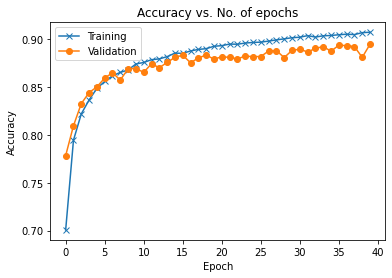

In [ ]:
plot_accuracy(train_accuracies, val_accuracies)

In [ ]:
def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")

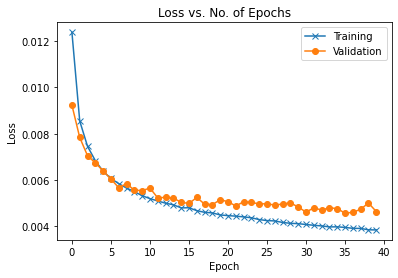

In [ ]:
plot_losses(train_losses, val_losses)

## Train a model on the entire dataset

In [ ]:
indices, _ = split_indices(len(dataset), 0, rand_seed)

sampler = SubsetRandomSampler(indices)
dl = DataLoader(dataset, batch_size, sampler=sampler)
dl = DeviceDataLoader(dl, device)

**Set the maximum number of training epochs and the learning rate for finetuning your model.**

In [ ]:
######################
#   YOUR CODE HERE   #
######################
num_epochs = 30
lr = 1e-4

In [ ]:
history = train_model(num_epochs, model, dl, [], loss_fn, opt_fn, lr)
model = history[0]

[1] train acc: 0.9062166666666667 train loss: 0.003914905818986396
[2] train acc: 0.9064 train loss: 0.00391417796574533
[3] train acc: 0.9086 train loss: 0.0038403543113420405
[4] train acc: 0.9089 train loss: 0.003826269124696652
[5] train acc: 0.9073 train loss: 0.0038555901183436312
[6] train acc: 0.9094 train loss: 0.0037767666921019556
[7] train acc: 0.9097666666666666 train loss: 0.003766595826484263
[8] train acc: 0.90855 train loss: 0.0037572350639849903
[9] train acc: 0.9105 train loss: 0.0037096554923802616
[10] train acc: 0.90945 train loss: 0.003731954211431245
[11] train acc: 0.9088833333333334 train loss: 0.003724467593058944
[12] train acc: 0.91055 train loss: 0.003672573632374406
[13] train acc: 0.9107666666666666 train loss: 0.003706051179828743
[14] train acc: 0.91165 train loss: 0.003632860331858198
[15] train acc: 0.9117333333333333 train loss: 0.0036654338309541346
[16] train acc: 0.9104166666666667 train loss: 0.003665987919208904
[17] train acc: 0.91035 train lo

## Check Predictions

In [ ]:
def view_prediction(img, label, probs, classes):
    """
    Visualize predictions.
    """
    probs = probs.cpu().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(8,15), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).cpu().numpy().squeeze(), cmap='Greys_r')
    ax1.axis('off')
    ax1.set_title('Actual: {}'.format(classes[label]))
    ax2.barh(np.arange(10), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes, size='small');
    ax2.set_title('Predicted: probabilities')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

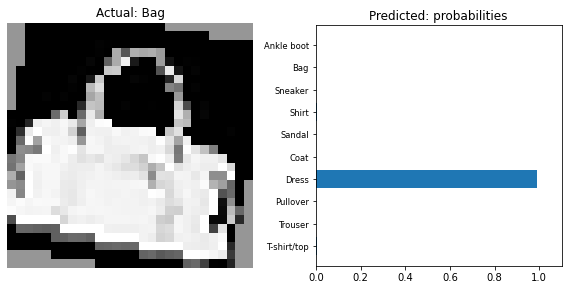

In [ ]:
# Calculate the class probabilites (log softmax) for img
images = iter(dl)
for imgs, labels in images:
    with torch.no_grad():
        model.eval()
        # Calculate the class probabilites (log softmax) for img
        probs = torch.nn.functional.softmax(model(imgs[0].unsqueeze(0)), dim=1)
        # Plot the image and probabilites
        view_prediction(imgs[14], labels[14], probs, dataset.classes)
    break

## Save the model

In [ ]:
# Very important
torch.save(model, 'model')

## Question 4

## Compute accuracy on the test set

In [ ]:
test_dataset = FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

In [ ]:
test_dl = DataLoader(test_dataset, batch_size)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
def evaluate(model, test_dl):
    """
    Evaluates your model on the test data.
    
    Args:
        model: ImageClassifierNet object
        test_dl: test dataloader
    
    Returns: 
        Test accuracy.
    """
    ######################
    #   YOUR CODE HERE   #
    ######################
    with torch.no_grad():
      test_acc, test_count = 0.0, 0
      for i, data in enumerate(test_dl, 0):
        inputs, labels = data
        labels = labels.cuda()
        outputs = model(inputs.cuda())
        op = torch.argmax(outputs, dim=1)
        test_acc += torch.sum( op == labels) 
        test_count += labels.shape[0]
        del inputs, labels, outputs
        torch.cuda.empty_cache()
      return test_acc.item() / test_count

In [ ]:
print("Test Accuracy = {:.4f}".format(evaluate(model, test_dl)))

Test Accuracy = 0.8893


## Preparing the CSV for Kaggle submission

In [ ]:
import zipfile
from tqdm import tqdm
from torchvision.io import read_image
!wget --no-check-certificate \
    "https://people.tamu.edu/~sumedhpendurkar/csce633/test_private/dataset.zip" \
    -O "/tmp/dataset.zip"
zip_ref = zipfile.ZipFile('/tmp/dataset.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2022-05-04 22:50:43--  https://people.tamu.edu/~sumedhpendurkar/csce633/test_private/dataset.zip
Resolving people.tamu.edu (people.tamu.edu)... 128.194.54.37
Connecting to people.tamu.edu (people.tamu.edu)|128.194.54.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6101143 (5.8M) [application/zip]
Saving to: ‘/tmp/dataset.zip’

/tmp/dataset.zip    100%[===================>]   5.82M  5.84MB/s    in 1.0s    

2022-05-04 22:50:44 (5.84 MB/s) - ‘/tmp/dataset.zip’ saved [6101143/6101143]



In [ ]:
from torch.utils.data import Dataset
import pandas as pd
from tqdm import tqdm
class PrivateImageDataset(Dataset):
    def __init__(self, base_path, length, transform=None):
        self.base_path = base_path
        self.transform = transform
        self.length = length

    def __len__(self):
        return (self.length)

    def __getitem__(self, idx):
        path = self.base_path + str(idx) + '.png'
        im = Image.open(path)
        if self.transform:
            image = self.transform(im)
        return image, 0

In [ ]:
def get_test_labels(model, dataset_size):
    test_dataset = PrivateImageDataset('/tmp/', dataset_size, transform=transform)
    test_dl = DataLoader(test_dataset, batch_size)
    test_dl = DeviceDataLoader(test_dl, device)
    preds, labels = [], []
    with torch.no_grad():
        model.eval()
        
        for i, data in tqdm(enumerate(test_dl)):
            xb, yb = data
            y_pred = model(xb)
            _, y = torch.max(y_pred, dim=1)
            preds.extend(y_pred)
            labels.extend(y)
    return preds, labels

In [ ]:
def create_csv_for_kaggle(model):
    dataset_size = 10000
    _, labels = get_test_labels(model, dataset_size)
    data = []
    for i in range(len(labels)):
        data.append([str(i) + '.png', labels[i].item()])
    df = pd.DataFrame(data, columns=['id', 'label'])
    df.to_csv('/home/submission.csv',index=False)
    return df
    


In [ ]:
create_csv_for_kaggle(model)

157it [00:09, 17.24it/s]


,id,label
0,0.png,9
1,1.png,2
2,2.png,1
3,3.png,1
4,4.png,0
...,...,...
9995,9995.png,9
9996,9996.png,1
9997,9997.png,8
9998,9998.png,1


## Tips to increase the test accuracy

- **Data augmentation:** Diversifies your training set and leads to better generalization
    - Flipping
    - Rotation
    - Shifting
    - Cropping
    - Adding noise
    - Blurring
    
- **Regularization:** Reduces overfitting on the training set
    - Early stopping
    - Dropout
    - $l_2$ regularization
    - Batch normalization

- **Hyperparameter tuning:**
    - Weight initialization
    - Learning rate
    - Activation functions
    - Optimizers